# Microplastic Data Analysis and Visualization

This notebook analyzes microplastic concentration data from various countries. It involves:
- Importing and cleaning the dataset
- Converting concentration units to a standardized measure
- Aggregating data by country and identification method
- Visualizing trends such as total and average concentrations, as well as comparisons between countries (e.g., USA vs Germany)

In [160]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Display the first few rows to get an overview of the data structure
df.head()

# Check for null values across all columns to assess data quality
df.isnull().sum()

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64

### Data Overview
The dataset is loaded and inspected for missing values. This step ensures that any subsequent cleaning or preprocessing accurately addresses data quality issues.

In [161]:
# Drop rows with missing values in key columns
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

# Convert 'Concentration' to numeric, coercing non-numeric values to NaN
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Create a clean copy for further processing
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

### Unit Conversion
Using a helper function, the `Concentration` values are converted to a consistent unit (particles/L) and stored in a new column, `Concentration_std`. This ensures that we can compare values across different measurement units.

In [162]:
# Define a function to convert various concentration units to particles/L
def convert_concentration(value, unit):
    conversion_factors = {
        'particles/L': 1,
        'particles/0.33 L': 1 / 0.33,
        'particles/50 L': 1 / 50,
        'particles/mL': 1000,
        'particles/m3': 1 / 1000
    }
    if np.isnan(value) or unit not in conversion_factors:
        return np.nan
    else:
        return value * conversion_factors[unit]

# Apply the conversion to standardize the concentration values
df['Concentration_std'] = df.apply(
    lambda row: convert_concentration(row['Concentration'], row['Concentration_Units']),
    axis=1
)

### Data Aggregation by Country
The dataset is grouped by `Countries` to calculate both total and average microplastic concentration values. To ensure statistical validity, only countries with at least 10 samples are included.

In [163]:
# Aggregate total and average standardized concentration by country, along with sample counts
country_stats = df.groupby('Countries').agg(
    total_std_concentration=('Concentration_std', 'sum'),
    avg_std_concentration=('Concentration_std', 'mean'),
    sample_count=('Concentration_std', 'count')
).reset_index()

# Filter out countries with fewer than 10 samples for robust analysis
country_stats = country_stats[country_stats['sample_count'] >= 10]

# For plotting, identify the top 10 countries by total and average concentrations
top10_total = country_stats.sort_values(by='total_std_concentration', ascending=False).head(10)
top10_total = top10_total.sort_values(by='total_std_concentration', ascending=True)

top10_avg = country_stats.sort_values(by='avg_std_concentration', ascending=False).head(10)
top10_avg = top10_avg.sort_values(by='avg_std_concentration', ascending=True)

#### Bar Plot: Total Concentrations
This bar plot displays the total microplastic concentration (standardized to particles/L) for the top 10 countries with sufficient samples. Each bar is labeled with the respective concentration value.

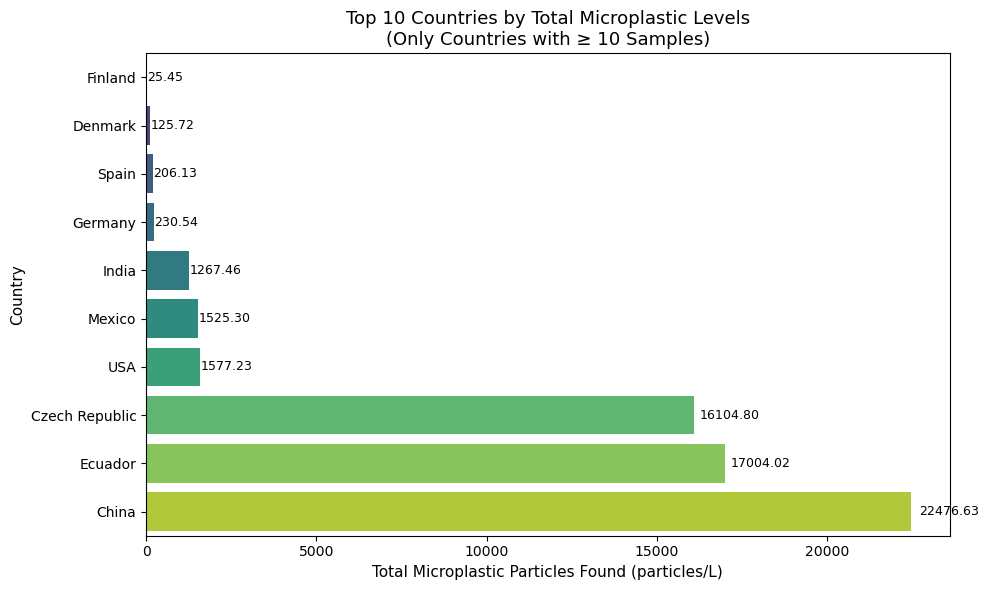

In [164]:
# Plot: Top 10 Countries by Total Standardized Concentration
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=top10_total, x='total_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Total Microplastic Particles Found (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Total Microplastic Levels\n(Only Countries with ≥ 10 Samples)', fontsize=13)

# Annotate bars with the total concentration values
for patch in ax1.patches:
    width = patch.get_width()
    ax1.text(width + (width * 0.01),
             patch.get_y() + patch.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

#### Bar Plot: Average Concentrations
This plot shows the average microplastic concentration for the top 10 countries, again only considering those with at least 10 samples.

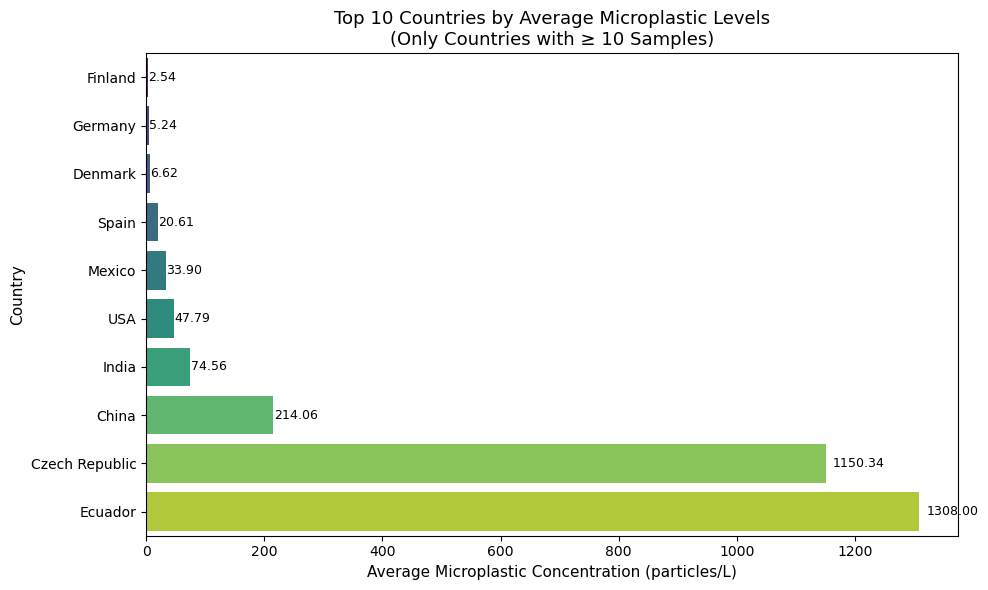

In [165]:
# Plot: Top 10 Countries by Average Standardized Concentration
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=top10_avg, x='avg_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Average Microplastic Concentration (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Average Microplastic Levels\n(Only Countries with ≥ 10 Samples)', fontsize=13)

# Annotate bars with the average concentration values
for patch in ax2.patches:
    width = patch.get_width()
    ax2.text(width + (width * 0.01),
             patch.get_y() + patch.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

#### Count Plot: Filtration Methods (USA vs Germany)
This plot shows the number of samples for each identification (filtration) method for the USA and Germany.

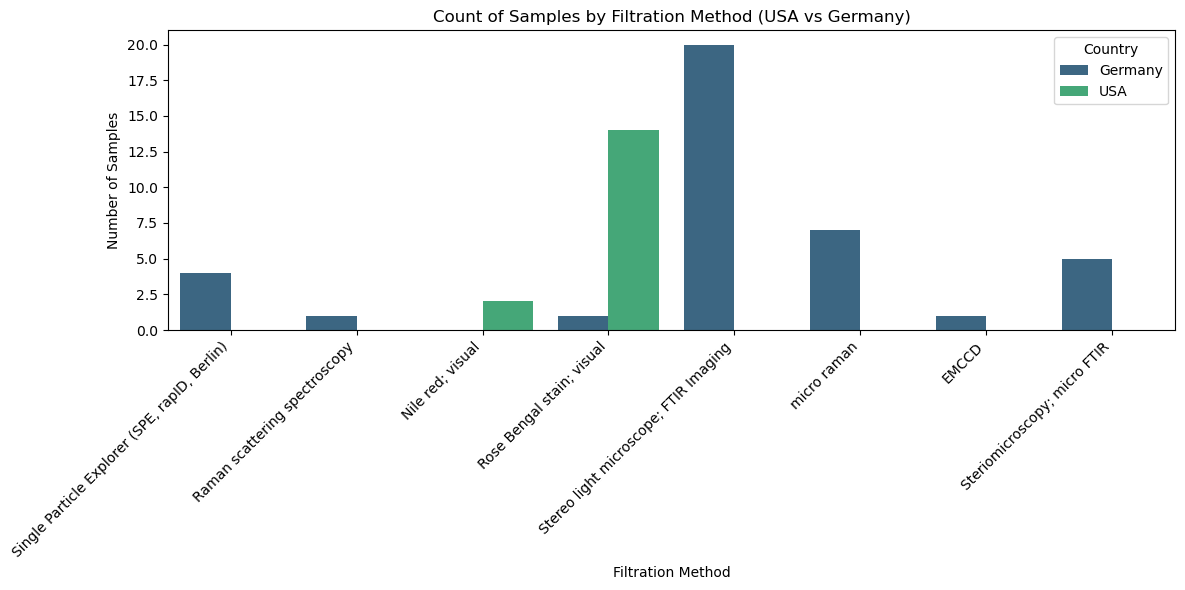

In [166]:
# Filter data for USA and Germany
df = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows with "Not Provided" in the identification method
df = df[df['Microplastic_Identification_Method'] != "Not Provided"]

# Plot: Count of Samples by Filtration (Identification) Method for USA vs Germany
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Microplastic_Identification_Method', hue='Countries', palette='viridis')
plt.title('Count of Samples by Filtration Method (USA vs Germany)')
plt.xlabel('Filtration Method')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

#### Effectiveness Analysis
This section classifies samples as "Effective" or "Ineffective" based on a defined concentration threshold and displays the proportions using a stacked bar chart.

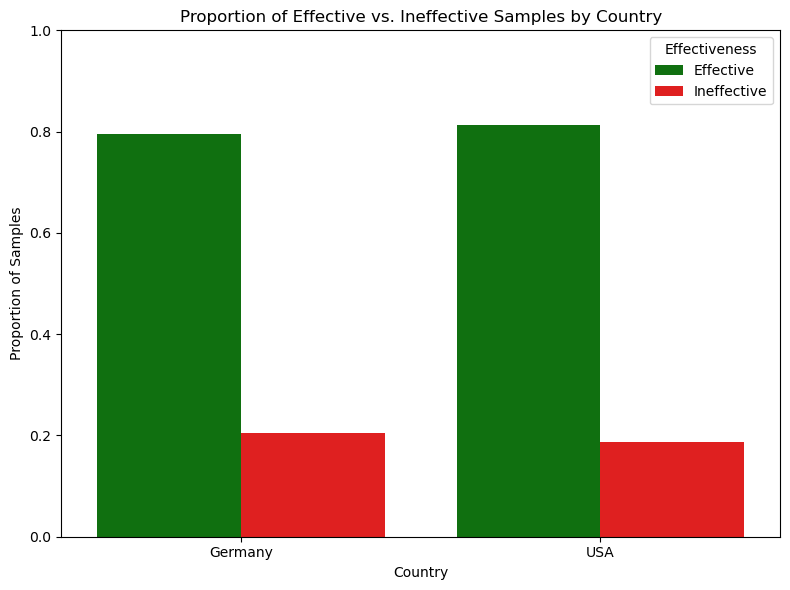

In [167]:
# Define threshold for effectiveness
threshold = 10
df['Effectiveness'] = df['Concentration'].apply(lambda x: 'Effective' if x < threshold else 'Ineffective')

# Group by Country and Effectiveness and calculate sample counts
eff_summary = df.groupby(['Countries', 'Effectiveness']).size().unstack(fill_value=0)

# Convert raw counts to proportions for each country
eff_prop = eff_summary.div(eff_summary.sum(axis=1), axis=0).reset_index()

# Reshape data for plotting
eff_melted = eff_prop.melt(id_vars='Countries', var_name='Effectiveness', value_name='Proportion')

plt.figure(figsize=(8, 6))
sns.barplot(data=eff_melted, x='Countries', y='Proportion', hue='Effectiveness', palette=['green', 'red'])
plt.title('Proportion of Effective vs. Ineffective Samples by Country')
plt.xlabel('Country')
plt.ylabel('Proportion of Samples')
plt.ylim(0, 1)
plt.legend(title='Effectiveness')
plt.tight_layout()
plt.show()

### Microplastic Concentration by Filtration Method

This cell:
- Loads and cleans the dataset by removing rows missing location information.
- Converts the **Concentration** column to numeric and drops rows where conversion fails.
- Renames the `Microplastic_Identification_Method` column to `Identification_Method` for clarity.
- Groups the data by identification method, calculating the total concentration and sample count.
- Filters to keep only methods with at least 5 samples, then selects the top 10 by total concentration.
- Plots a bar chart of the top 10 methods.

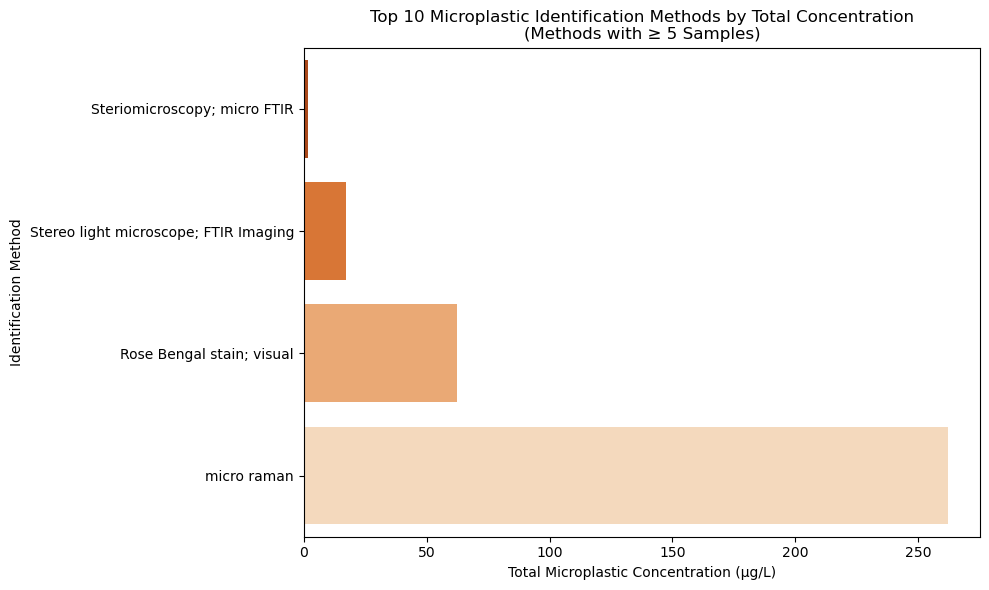

In [168]:
# Assumes df is already loaded and cleaned earlier in the narrative
# Drop rows missing location details if needed (already done during cleaning)
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])

# Convert Concentration to numeric if not already done
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration'])

# Rename the identification method column for clarity
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Group by identification method and calculate sum of concentration and sample count
method_stats = df.groupby('Identification_Method').agg(
    total_concentration=('Concentration', 'sum'),
    sample_count=('Concentration', 'count')
).reset_index()

# Retain only methods with at least 5 samples and select top 10 by total concentration
method_stats = method_stats[method_stats['sample_count'] >= 5]
top10_methods = method_stats.sort_values(by='total_concentration', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_methods.sort_values(by='total_concentration'),
    x='total_concentration',
    y='Identification_Method',
    palette='Oranges_r'
)
plt.xlabel("Total Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Total Concentration\n(Methods with ≥ 5 Samples)")
plt.tight_layout()
plt.show()

### Average Microplastic Concentration by Filtration Method (USA vs Germany)

This cell:
- Loads and cleans the dataset (ensuring location, latitude, and concentration information are complete).
- Renames the identification column.
- Finds the top 10 most common identification methods.
- Filters the dataset to keep only these common methods.
- Computes the average microplastic concentration for each method and plots them.

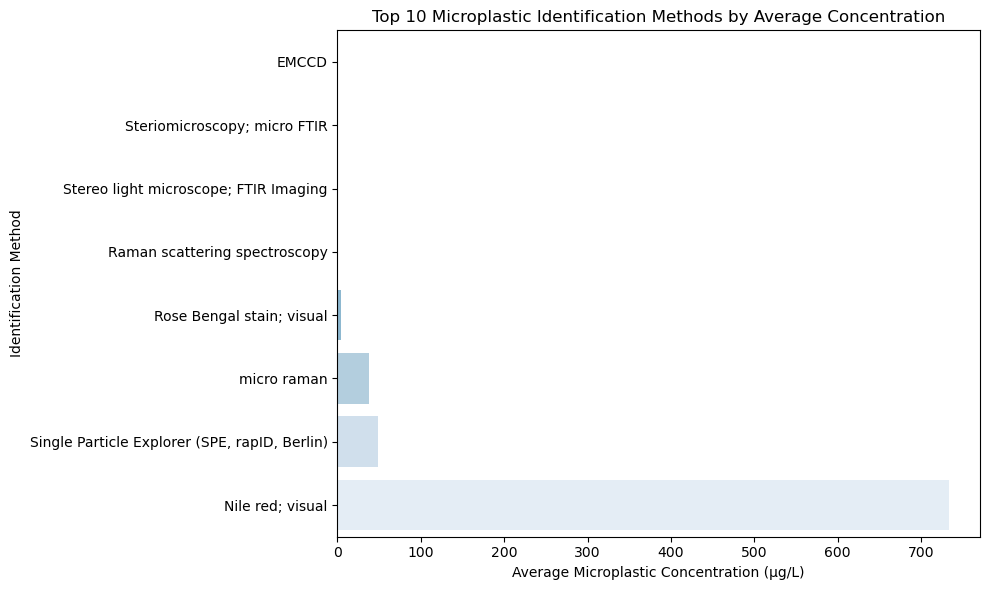

In [169]:
# Assumes df is already loaded and cleaned
# Rename the column if not done already
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Identify the top 10 most common identification methods
top_methods = df['Identification_Method'].value_counts().head(10).index
filtered_df = df[df['Identification_Method'].isin(top_methods)]

# Compute the average concentration for each method
mean_conc = filtered_df.groupby('Identification_Method')['Concentration'].mean().sort_values()

# Plot average concentration for each identification method
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')
plt.xlabel("Average Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Average Concentration")
plt.tight_layout()
plt.show()

###  Average Microplastic Concentration by Filtration Method (USA vs Germany)
This cell identifies the top 10 most common identification methods, filters the dataset to include these methods, calculates the average concentration for each, and plots the results in a horizontal bar chart.

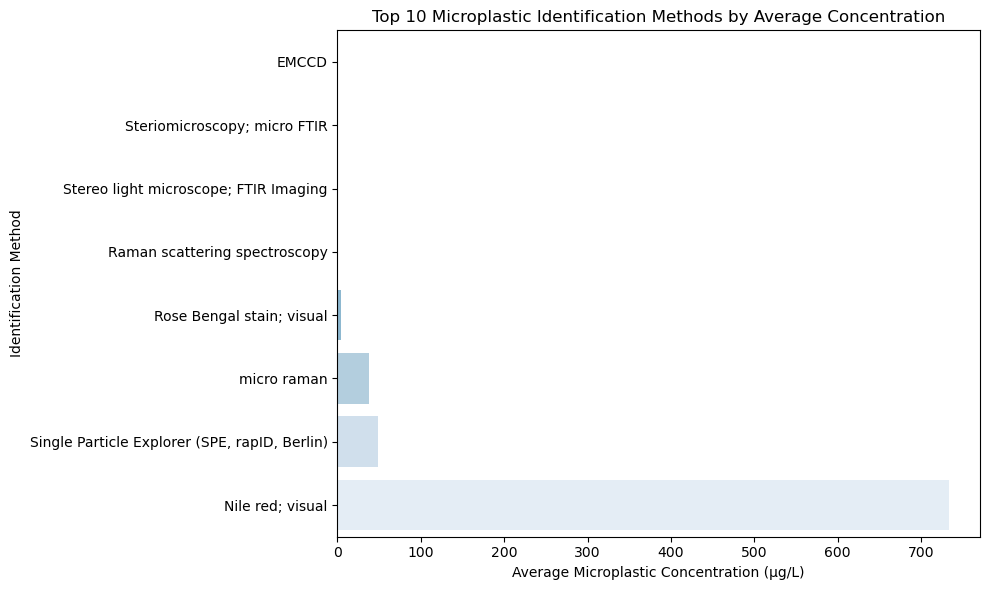

In [170]:
# Rename the column for clarity if not done already
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Identify the top 10 most common identification methods
top_methods = df['Identification_Method'].value_counts().head(10).index
filtered_df = df[df['Identification_Method'].isin(top_methods)]

# Compute the average concentration for each method
mean_conc = filtered_df.groupby('Identification_Method')['Concentration'].mean().sort_values()

# Plot the average concentration
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')
plt.xlabel("Average Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Average Concentration")
plt.tight_layout()
plt.show()

### Box Plot of Microplastic Concentration by Identification Method (USA vs Germany)
This cell creates a box plot to compare the distribution of microplastic concentrations across different identification methods between USA and Germany.

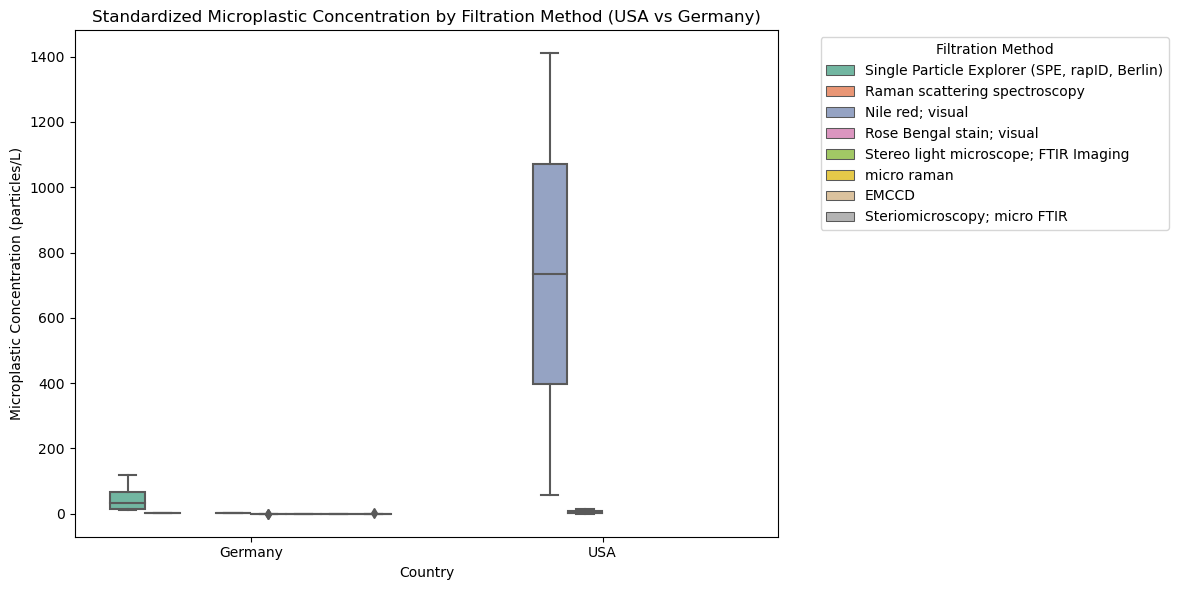

['Germany' 'USA']


In [187]:
# Filter the dataset for USA and Germany using .isin()
usa_ger = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows with "Not Provided" in the identification method
usa_ger = usa_ger[usa_ger['Identification_Method'] != "Not Provided"]

# Create the box plot comparing standardized concentrations by identification method and country
plt.figure(figsize=(12, 6))
sns.boxplot(x='Countries', y='Concentration_std', hue='Identification_Method', data=usa_ger, palette='Set2')
plt.title('Standardized Microplastic Concentration by Filtration Method (USA vs Germany)')
plt.xlabel('Country')
plt.ylabel('Microplastic Concentration (particles/L)')
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confirm both USA and Germany are present
print(usa_ger['Countries'].unique())

In [184]:
usa_ger['Countries'].unique()

array(['Germany', 'USA'], dtype=object)

### 4b. Stacked Bar Chart of Filtration Methods by Country
This cell removes samples with a "Not Provided" identification, groups the data by country and identification method, and plots a stacked bar chart to show sample counts.

<Figure size 1200x600 with 0 Axes>

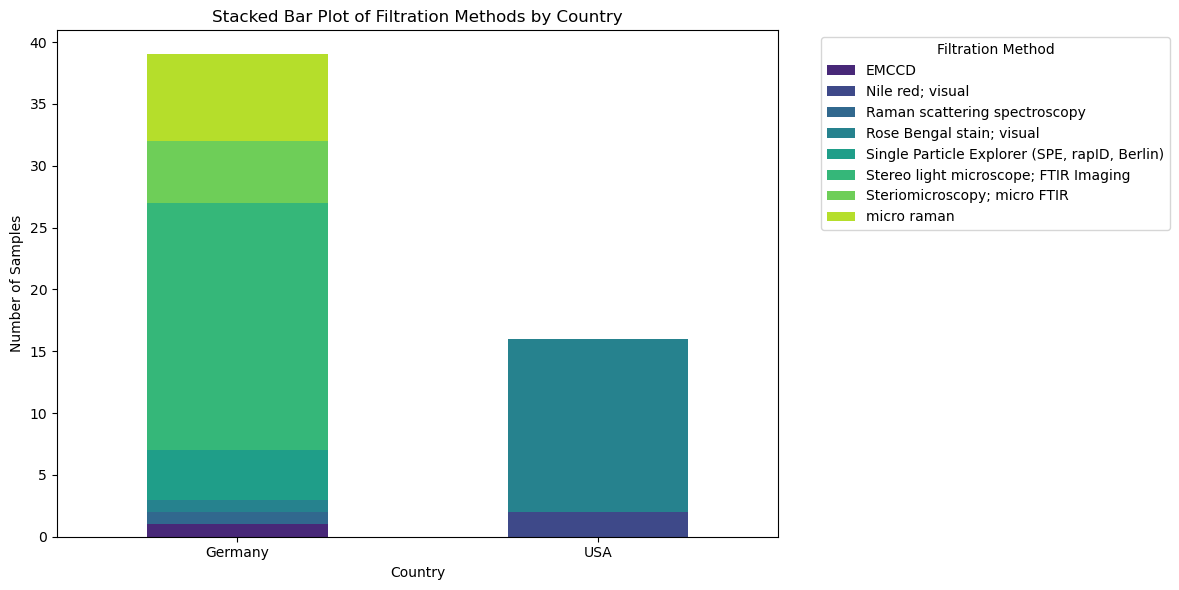

In [188]:
# Remove samples with "Not Provided" in the identification method
usa_ger = usa_ger[usa_ger['Identification_Method'] != "Not Provided"]

# Group by Countries and Identification Method to get sample counts
country_method_counts = usa_ger.groupby(['Countries', 'Identification_Method']).size().unstack()

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
country_method_counts.plot(kind='bar', stacked=True, figsize=(12, 6),
                           color=sns.color_palette('viridis', n_colors=len(country_method_counts.columns)))
plt.title('Stacked Bar Plot of Filtration Methods by Country')
plt.xlabel('Country')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Comparison of Concentration by Water Source (Bottle vs. Tap)
This cell aggregates total concentration by country and water source, then creates subplots to compare the total concentration for each water source between Germany and USA.

### 4d. Standardizing Concentration Units and Total Concentration in g/L
This cell defines a conversion function to standardize the concentration units to particles/L, applies it to create a new column, groups by country to sum the standardized concentration, converts the total from µg/L to g/L, and prints the result.